
# DigitClassifier: Optical Recognition of Handwritten Digits
**Done by:** Amay Waykool

 

---

This notebook demonstrates the development of a neural network model to recognize handwritten digits. It uses a training dataset to teach the network to identify digits (0-9) based on their features and applies the trained model to predict digits in a separate test dataset. The implementation employs Multi-Layer Perceptrons (MLP), focusing on forward propagation, activation functions, and iterative weight adjustments through training.



## Setup  

In this section, we configure the environment for model development. This involves loading the datasets, defining necessary mathematical and neural network functions, and initializing parameters for training the Multi-Layer Perceptron model.

---



### Explanation  
This segment imports essential Python libraries:  
- **NumPy**: Provides mathematical operations like matrix multiplication and random number generation.  
- **Pandas**: Simplifies data handling, allowing for easy loading and preprocessing of datasets.  

These libraries are critical for efficient numerical computation and data management.


In [13]:
import pandas as pd
import numpy as np


### Explanation  

This code loads the training and validation datasets:

- **Dataset Paths**

dataset1_path and dataset2_path specify the file paths for the training (cw2DataSet1.csv) and validation (cw2DataSet2.csv) datasets.

- **Loading Data:**

pd.read_csv() reads the CSV files into pandas DataFrames.
header=None means the files lack headers, so column names are assigned as integers.

- **Outputs:**

train_data: DataFrame holding the training data.
validation_data: DataFrame holding the validation data.
This prepares the datasets for preprocessing and training the model.





In [14]:
# Load the datasets
dataset1_path = 'cw2DataSet1.csv'
dataset2_path = 'cw2DataSet2.csv'

train_data = pd.read_csv(dataset1_path, header=None)
validation_data = pd.read_csv(dataset2_path, header=None)


### Explanation  

This function normalizes data to the range [0, 1]. It ensures all features have equal scale, which is important for machine learning models. The parameter X represents the input data, and epsilon is a small value added to avoid division by zero. The normalization is computed using the formula:

Normalized Value

$$
\text{Normalized Value} = \frac{X - \text{min}(X)}{\text{max}(X) - \text{min}(X) + \epsilon}
$$

The function returns the normalized data where all values are between 0 and 1.






In [15]:
# Normalize the data
def normalize_data(X):
    epsilon = 1e-8  # Small value to avoid division by zero
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0) + epsilon)


### Explanation  

This code prepares the data by splitting it into features and targets:

- **Features (X_train, X_val):** Extracted as all columns except the last one, then normalized using normalize_data.
- **Targets (y_train, y_val):** Extracted as the last column without normalization.
This ensures the datasets are ready for model training and validation.


In [16]:
# Prepare the data
X_train = normalize_data(train_data.iloc[:, :-1].values)  # Features
y_train = train_data.iloc[:, -1].values  # Targets

X_val = normalize_data(validation_data.iloc[:, :-1].values)
y_val = validation_data.iloc[:, -1].values



### Explanation  

This code defines essential preprocessing and activation functions:

- **One-Hot Encoding:** Converts target labels (y_train and y_val) into a matrix format where each row represents a label as a one-hot vector.

- **ReLU (relu) and Derivative:** ReLU sets negative values to 0 and keeps positives as-is. The derivative is used for backpropagation.

- **Softmax:** Converts output scores into probabilities, ensuring they sum to 1, which is vital for multi-class classification.

These functions prepare the data and enable non-linearity and probability handling in the model.


In [17]:
# One-hot encode the targets
def one_hot_encode(y, num_classes=10):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

y_train_encoded = one_hot_encode(y_train)
y_val_encoded = one_hot_encode(y_val)

# Define activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


### Explanation  

This code initializes the parameters for a Multi-Layer Perceptron (MLP):

**Network Configuration:**

- input_size: Number of input features (64 pixels for digit images).
- hidden_size1 and hidden_size2: Number of neurons in the first and second hidden layers (400 and 300).
- output_size: Number of output classes (10 digits: 0-9).

**Learning and Regularization:**

- learning_rate: Controls the size of weight updates during training.
- dropout_rate: Regularization rate to reduce overfitting.

**Weight Initialization:**

- Weights are initialized using Xavier initialization **(np.sqrt(2 / number of inputs))** for balanced scaling.
- weights_input_hidden1: Connects the input layer to the first hidden layer.
- weights_hidden1_hidden2: Connects the first hidden layer to the second.
- weights_hidden2_output: Connects the second hidden layer to the output layer.

**Bias Initialization:**

- bias_hidden1, bias_hidden2, and bias_output are initialized to zero.


In [18]:
# Initialize the MLP parameters
input_size = 64  # Number of features
hidden_size1 = 400  # First hidden layer neurons
hidden_size2 = 300  # Second hidden layer neurons
output_size = 10  # Number of output neurons (for digit classification: 0-9)
learning_rate = 0.012  # Learning rate
dropout_rate = 0.2  # Dropout rate for regularization

# Initialize weights
np.random.seed(42)
weights_input_hidden1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2 / input_size)
weights_hidden1_hidden2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2 / hidden_size1)
weights_hidden2_output = np.random.randn(output_size, hidden_size2) * np.sqrt(2 / hidden_size2)

# Initialize biases
bias_hidden1 = np.zeros((hidden_size1, 1))
bias_hidden2 = np.zeros((hidden_size2, 1))
bias_output = np.zeros((output_size, 1))


### Explanation  
This function performs forward propagation in the neural network:

**Hidden Layers:**

- Compute inputs using weights and biases, then activate using ReLU.
- Apply dropout if enabled to prevent overfitting.

**Output Layer:** Compute inputs and apply Softmax to produce class probabilities.

**Output:** Returns the activations of both hidden layers and the output layer.


In [19]:
# Define the feedforward function with dropout
def feedforward(X, dropout=False):
    global weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output
    global bias_hidden1, bias_hidden2, bias_output

    # Hidden layer 1
    hidden_layer1_input = np.dot(weights_input_hidden1, X.T) + bias_hidden1
    hidden_layer1_output = relu(hidden_layer1_input)
    if dropout:
        mask1 = np.random.rand(*hidden_layer1_output.shape) > dropout_rate
        hidden_layer1_output *= mask1
        hidden_layer1_output /= (1 - dropout_rate)

    # Hidden layer 2
    hidden_layer2_input = np.dot(weights_hidden1_hidden2, hidden_layer1_output) + bias_hidden2
    hidden_layer2_output = relu(hidden_layer2_input)
    if dropout:
        mask2 = np.random.rand(*hidden_layer2_output.shape) > dropout_rate
        hidden_layer2_output *= mask2
        hidden_layer2_output /= (1 - dropout_rate)

    # Output layer
    output_layer_input = np.dot(weights_hidden2_output, hidden_layer2_output) + bias_output
    output_layer_output = softmax(output_layer_input)

    return hidden_layer1_output, hidden_layer2_output, output_layer_output


### Explanation  

This function implements backpropagation, which adjusts weights and biases to minimize prediction errors:

**Output Layer Error:**

- Calculates the difference (output_error) between the predicted output and the actual target.
- output_delta: Represents the gradient for the output layer.

**Hidden Layers Error:**

- Hidden Layer 2: Propagates the output error backward to compute hidden2_error.
- hidden2_delta: The error scaled by the ReLU derivative.
- Hidden Layer 1: Similarly propagates hidden2_delta to compute hidden1_error and scales it.

**Weights and Biases Update:**

- Updates the weights and biases for all layers using the gradients (delta) and the learning rate.

This function enables the network to learn by iteratively reducing the error through gradient descent.


In [20]:
# Define the backpropagation function
def backpropagation(X, y, hidden_output1, hidden_output2, output_output):
    global weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output
    global bias_hidden1, bias_hidden2, bias_output

    # Output layer error
    output_error = y.T - output_output
    output_delta = output_error

    # Hidden layer 2 error
    hidden2_error = np.dot(weights_hidden2_output.T, output_delta)
    hidden2_delta = hidden2_error * relu_derivative(hidden_output2)

    # Hidden layer 1 error
    hidden1_error = np.dot(weights_hidden1_hidden2.T, hidden2_delta)
    hidden1_delta = hidden1_error * relu_derivative(hidden_output1)

    # Update weights and biases
    weights_hidden2_output += learning_rate * np.dot(output_delta, hidden_output2.T)
    bias_output += learning_rate * np.sum(output_delta, axis=1, keepdims=True)

    weights_hidden1_hidden2 += learning_rate * np.dot(hidden2_delta, hidden_output1.T)
    bias_hidden2 += learning_rate * np.sum(hidden2_delta, axis=1, keepdims=True)

    weights_input_hidden1 += learning_rate * np.dot(hidden1_delta, X)
    bias_hidden1 += learning_rate * np.sum(hidden1_delta, axis=1, keepdims=True)

### Explanation

This code trains the MLP using mini-batch gradient descent:

- **Epochs:** Repeats the training process for 100 iterations.
- **Mini-Batches:** Splits data into batches of size 64 for efficient updates.
- **Training Process:** Performs forward propagation to predict outputs and compares predictions with actual labels and updates weights using backpropagation.
- **Accuracy:** Calculates and prints training accuracy every 10 epochs.
This process refines the model by minimizing errors over multiple iterations.


In [21]:
# Training the MLP
epochs = 100  # Increased number of training epochs
batch_size = 64  # Use mini-batch gradient descent
for epoch in range(epochs):
    correct_predictions = 0
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train_encoded[i:i+batch_size]
        for X_sample, y_sample in zip(X_batch, y_batch):
            X_sample = X_sample.reshape(1, -1)
            y_sample = y_sample.reshape(1, -1)
            hidden_output1, hidden_output2, output_output = feedforward(X_sample, dropout=True)
            if np.argmax(output_output) == np.argmax(y_sample):
                correct_predictions += 1
            backpropagation(X_sample, y_sample, hidden_output1, hidden_output2, output_output)

    # Calculate accuracy
    accuracy = correct_predictions / X_train.shape[0]
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Training Accuracy: {accuracy * 100:.2f}%")

Epoch 10/100 - Training Accuracy: 99.15%
Epoch 20/100 - Training Accuracy: 99.54%
Epoch 30/100 - Training Accuracy: 99.72%
Epoch 40/100 - Training Accuracy: 99.86%
Epoch 50/100 - Training Accuracy: 99.82%
Epoch 60/100 - Training Accuracy: 99.96%
Epoch 70/100 - Training Accuracy: 100.00%
Epoch 80/100 - Training Accuracy: 100.00%
Epoch 90/100 - Training Accuracy: 100.00%
Epoch 100/100 - Training Accuracy: 99.96%


### Explanation

This code tests the trained MLP on validation data:

**test_model:**

- Performs forward propagation for each validation sample (dropout disabled).
- Compares predictions with actual labels to count correct predictions.

**Accuracy:** Calculates and prints validation accuracy as the percentage of correct predictions.
This evaluates the model's performance on unseen data.

In [22]:
# Testing the MLP on the validation dataset
def test_model(X, y):
    correct_predictions = 0
    for X_sample, y_sample in zip(X, y):
        X_sample = X_sample.reshape(1, -1)
        y_sample = y_sample.reshape(1, -1)
        _, _, output_output = feedforward(X_sample, dropout=False)
        if np.argmax(output_output) == np.argmax(y_sample):
            correct_predictions += 1
    accuracy = correct_predictions / X.shape[0]
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Calculate validation accuracy
validation_accuracy = test_model(X_val, y_val_encoded)

Validation Accuracy: 97.76%


### Confusion Matrix - Fold 1

**Predictions and True Labels:**
- The code collects predicted labels (y_pred_fold1) using the feedforward function and true labels (y_true_fold1) from the validation data.

**Confusion Matrix:**
- It computes the confusion matrix by comparing y_true_fold1 (actual labels) with y_pred_fold1 (predicted labels).

**Visualization:**
- The confusion matrix is displayed using ConfusionMatrixDisplay with a blue colormap (plt.cm.Blues) and labeled as "Confusion Matrix for Fold 1"

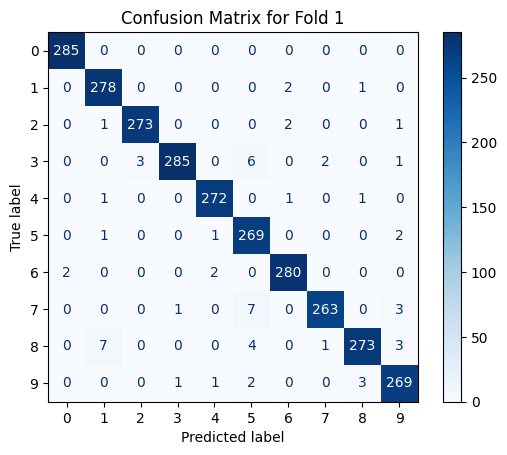

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions for Fold 1
y_pred_fold1 = []
y_true_fold1 = []

# Collect predictions and true labels for Fold 1
for X_sample, y_sample in zip(X_val, y_val):
    X_sample = X_sample.reshape(1, -1)  # Reshape input sample
    _, _, output_output = feedforward(X_sample, dropout=False)  # Get predictions
    y_pred_fold1.append(np.argmax(output_output))  # Predicted class (0-9)
    y_true_fold1.append(y_sample)  # True class (integer labels, 0-9)

# Generate the confusion matrix for Fold 1
cf_matrix_fold1 = confusion_matrix(y_true_fold1, y_pred_fold1)

# Display the confusion matrix for Fold 1
disp_fold1 = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_fold1, display_labels=np.arange(10))
disp_fold1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fold 1")
plt.show()

### Two-Fold Cross-Validation Explanation (Fold 2 Code)

**Dataset Swapping:**

This process ensures each dataset is evaluated as both training and validation data, providing a robust assessment of the model's generalization ability. Swapping datasets for Fold 2 reduces the likelihood of dataset-specific bias, and the averaged accuracy serves as the final performance metric.

In [26]:
import pandas as pd
import numpy as np

# Load the datasets
# Swapped the datasets for Fold 2
dataset1_path = 'cw2DataSet2.csv'
dataset2_path = 'cw2DataSet1.csv'

train_data_fold2 = pd.read_csv(dataset1_path, header=None)
validation_data_fold2 = pd.read_csv(dataset2_path, header=None)

# Normalize the data
def normalize_data(X):
    epsilon = 1e-8  # Small value to avoid division by zero
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0) + epsilon)


# Prepare the data for Fold 2
X_train_fold2 = normalize_data(train_data_fold2.iloc[:, :-1].values)  # Features
y_train_fold2 = train_data_fold2.iloc[:, -1].values  # Targets

X_val_fold2 = normalize_data(validation_data_fold2.iloc[:, :-1].values)
y_val_fold2 = validation_data_fold2.iloc[:, -1].values

# One-hot encode the targets for Fold 2
def one_hot_encode(y, num_classes=10):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

y_train_encoded_fold2 = one_hot_encode(y_train_fold2)
y_val_encoded_fold2 = one_hot_encode(y_val_fold2)

# Define activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

# Initialize the MLP parameters for Fold 2
input_size = 64
hidden_size1 = 400
hidden_size2 = 300
output_size = 10
learning_rate = 0.011
dropout_rate = 0.18

# Initialize weights
np.random.seed(42)
weights_input_hidden1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2 / input_size)
weights_hidden1_hidden2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2 / hidden_size1)
weights_hidden2_output = np.random.randn(output_size, hidden_size2) * np.sqrt(2 / hidden_size2)

# Initialize biases
bias_hidden1 = np.zeros((hidden_size1, 1))
bias_hidden2 = np.zeros((hidden_size2, 1))
bias_output = np.zeros((output_size, 1))


# Define the feedforward function with dropout
def feedforward(X, dropout=False):
    global weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output
    global bias_hidden1, bias_hidden2, bias_output

    # Hidden layer 1
    hidden_layer1_input = np.dot(weights_input_hidden1, X.T) + bias_hidden1
    hidden_layer1_output = relu(hidden_layer1_input)
    if dropout:
        mask1 = np.random.rand(*hidden_layer1_output.shape) > dropout_rate
        hidden_layer1_output *= mask1
        hidden_layer1_output /= (1 - dropout_rate)

    # Hidden layer 2
    hidden_layer2_input = np.dot(weights_hidden1_hidden2, hidden_layer1_output) + bias_hidden2
    hidden_layer2_output = relu(hidden_layer2_input)
    if dropout:
        mask2 = np.random.rand(*hidden_layer2_output.shape) > dropout_rate
        hidden_layer2_output *= mask2
        hidden_layer2_output /= (1 - dropout_rate)

    # Output layer
    output_layer_input = np.dot(weights_hidden2_output, hidden_layer2_output) + bias_output
    output_layer_output = softmax(output_layer_input)

    return hidden_layer1_output, hidden_layer2_output, output_layer_output


# Define the backpropagation function
def backpropagation(X, y, hidden_output1, hidden_output2, output_output):
    global weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output
    global bias_hidden1, bias_hidden2, bias_output

    # Output layer error
    output_error = y.T - output_output
    output_delta = output_error

    # Hidden layer 2 error
    hidden2_error = np.dot(weights_hidden2_output.T, output_delta)
    hidden2_delta = hidden2_error * relu_derivative(hidden_output2)

    # Hidden layer 1 error
    hidden1_error = np.dot(weights_hidden1_hidden2.T, hidden2_delta)
    hidden1_delta = hidden1_error * relu_derivative(hidden_output1)

    # Update weights and biases
    weights_hidden2_output += learning_rate * np.dot(output_delta, hidden_output2.T)
    bias_output += learning_rate * np.sum(output_delta, axis=1, keepdims=True)

    weights_hidden1_hidden2 += learning_rate * np.dot(hidden2_delta, hidden_output1.T)
    bias_hidden2 += learning_rate * np.sum(hidden2_delta, axis=1, keepdims=True)

    weights_input_hidden1 += learning_rate * np.dot(hidden1_delta, X)
    bias_hidden1 += learning_rate * np.sum(hidden1_delta, axis=1, keepdims=True)


# Training the MLP for Fold 2
epochs = 100
batch_size = 64
for epoch in range(epochs):
    correct_predictions = 0
    for i in range(0, X_train_fold2.shape[0], batch_size):
        X_batch = X_train_fold2[i:i+batch_size]
        y_batch = y_train_encoded_fold2[i:i+batch_size]
        for X_sample, y_sample in zip(X_batch, y_batch):
            X_sample = X_sample.reshape(1, -1)
            y_sample = y_sample.reshape(1, -1)
            hidden_output1, hidden_output2, output_output = feedforward(X_sample, dropout=True)
            if np.argmax(output_output) == np.argmax(y_sample):
                correct_predictions += 1
            backpropagation(X_sample, y_sample, hidden_output1, hidden_output2, output_output)

    # Calculate accuracy
    accuracy = correct_predictions / X_train_fold2.shape[0]
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Training Accuracy for Fold 2: {accuracy * 100:.2f}%")


# Testing the MLP on the Fold 2 validation dataset
def test_model(X, y):
    correct_predictions = 0
    for X_sample, y_sample in zip(X, y):
        X_sample = X_sample.reshape(1, -1)
        y_sample = y_sample.reshape(1, -1)
        _, _, output_output = feedforward(X_sample, dropout=False)
        if np.argmax(output_output) == np.argmax(y_sample):
            correct_predictions += 1
    accuracy = correct_predictions / X.shape[0]
    print(f"Validation Accuracy for Fold 2: {accuracy * 100:.2f}%")
    return accuracy

# Calculate validation accuracy for Fold 2
validation_accuracy_fold2 = test_model(X_val_fold2, y_val_encoded_fold2)

# Average accuracy across both folds
average_accuracy = (validation_accuracy + validation_accuracy_fold2) / 2
print(f"Final 2-Fold Cross-Validation Accuracy: {average_accuracy * 100:.2f}%")


Epoch 10/100 - Training Accuracy for Fold 2: 99.32%
Epoch 20/100 - Training Accuracy for Fold 2: 99.54%
Epoch 30/100 - Training Accuracy for Fold 2: 100.00%
Epoch 40/100 - Training Accuracy for Fold 2: 99.86%
Epoch 50/100 - Training Accuracy for Fold 2: 99.86%
Epoch 60/100 - Training Accuracy for Fold 2: 100.00%
Epoch 70/100 - Training Accuracy for Fold 2: 99.96%
Epoch 80/100 - Training Accuracy for Fold 2: 99.89%
Epoch 90/100 - Training Accuracy for Fold 2: 99.96%
Epoch 100/100 - Training Accuracy for Fold 2: 99.96%
Validation Accuracy for Fold 2: 98.11%
Final 2-Fold Cross-Validation Accuracy: 97.94%


### Confusion Matrix - Fold 2

**Predictions and Labels:** Collects predicted labels (y_pred_fold2) using the feedforward function and true labels (y_true_fold2) from the Fold 2 validation set.

**Confusion Matrix:** Compares true labels (y_true_fold2) with predicted labels (y_pred_fold2) to generate the confusion matrix.

**Visualization:** Displays the confusion matrix using ConfusionMatrixDisplay with an orange colormap (plt.cm.Oranges) and labels it as "Confusion Matrix for Fold 2".

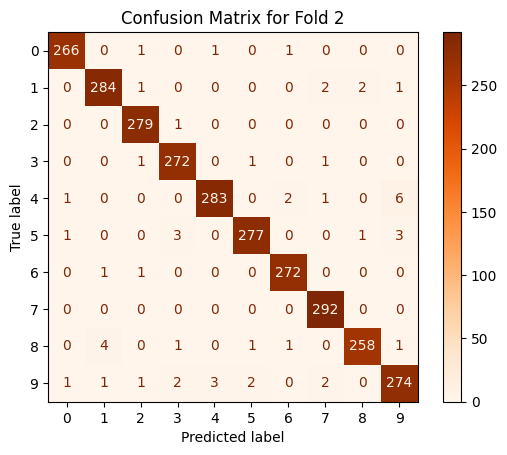

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions for Fold 2
y_pred_fold2 = []
y_true_fold2 = []

# Collect predictions and true labels for Fold 2
for X_sample, y_sample in zip(X_val_fold2, y_val_fold2):
    X_sample = X_sample.reshape(1, -1)  # Reshape input sample
    _, _, output_output = feedforward(X_sample, dropout=False)  # Get predictions
    y_pred_fold2.append(np.argmax(output_output))  # Predicted class (0-9)
    y_true_fold2.append(y_sample)  # True class (integer labels, 0-9)

# Generate the confusion matrix for Fold 2
cf_matrix_fold2 = confusion_matrix(y_true_fold2, y_pred_fold2)

# Display the confusion matrix for Fold 2
disp_fold2 = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_fold2, display_labels=np.arange(10))
disp_fold2.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix for Fold 2")
plt.show()


In [ ]:
# end